In [1]:
%matplotlib inline
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import json
import math

data = None

with open('data/yelp_academic_dataset_review.json') as f: 
    texts = []
    stars = [] 
    
    for line in f.readlines(): 
        row = json.loads(line)
        nstars = float(row['stars'])
        if not math.isnan(nstars):
            if math.isnan(nstars):
                raise 'WAT'
            texts.append(row['text'])
            stars.append(nstars) 
        
    data = pd.DataFrame({
        'texts' : texts,
        'stars' : stars
    })
    
data.to_csv('data/all_filtered_nans.tsv', sep='\t')

In [6]:
raw_data = pd.read_csv('data/all_filtered_nans.tsv', sep='\t', index_col=0)

/place/home/crossby/others/masters/bsu-masters/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
NTOTAL = 500000
MAX_NB_WORDS = 1000000
FASTTEXT_EMBEDDING_DIM = 300
WORD2VEC_EMBEDDING_DIM = 300
MAXLEN=100

NN_TRAIN_SPLIT = 0.7
NN_VALIDATION_SPLIT = 0.1
CLF_TRAIN_SPLIT = 0.1 
N_INTERVALS = 20

In [9]:
raw_data = raw_data[NTOTAL:2*NTOTAL]

In [30]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
texts = [str(txt) for txt in raw_data.texts.values]

tokenizer.fit_on_texts(texts)
print('Tokenizer fitted.')
sequences = tokenizer.texts_to_sequences(texts) 
print('Tokenizer applied.')

word_index = tokenizer.word_index 
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAXLEN) 
labels = raw_data.stars.values

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# indices = np.arange(data.shape[0])
# np.random.shuffle(indices)
# with open('indices.npy' , 'wb') as f:
#     np.save(f, indices)

indices = None
with open('indices.npy' , 'rb') as f:
    indices = np.load(f)
    
texts = [texts[i] for i in indices]
data = data[indices]
labels = labels[indices]

N_nn_train = int(NN_TRAIN_SPLIT * data.shape[0])
N_nn_val = int(NN_VALIDATION_SPLIT * data.shape[0]) 
N_clf_train = int(CLF_TRAIN_SPLIT * data.shape[0])

texts_train = texts[: N_nn_train]
x_train = data[: N_nn_train]
y_train = labels[: N_nn_train]

texts_val = texts[N_nn_train : N_nn_train + N_nn_val]
x_val = data[N_nn_train : N_nn_train + N_nn_val]
y_val = labels[N_nn_train : N_nn_train + N_nn_val]

X_clf_train = data[N_nn_train + N_nn_val: N_nn_train + N_nn_val + N_clf_train]
Y_clf_train = labels[N_nn_train + N_nn_val: N_nn_train + N_nn_val + N_clf_train]

X_test = data[N_nn_train + N_nn_val + N_clf_train:]
Y_test = labels[N_nn_train + N_nn_val + N_clf_train:]

In [13]:
N_clf_train = int(CLF_TRAIN_SPLIT * data.shape[0])

X_clf_train = data[N_nn_train + N_nn_val: N_nn_train + N_nn_val + N_clf_train]
Y_clf_train = labels[N_nn_train + N_nn_val: N_nn_train + N_nn_val + N_clf_train]

X_test = data[N_nn_train + N_nn_val + N_clf_train:]
Y_test = labels[N_nn_train + N_nn_val + N_clf_train:]

In [150]:
def smooth(arr, nwindow):
    res = []
    for i in range(len(arr)):
        window = arr[max(0, i - nwindow//2) : min(len(arr), i + 1 + nwindow//2)]
        res.append(sum(window) / len(window))
    return res

def draw_models(models, pattern, ignore, _nwindow=1, _mae=False):
    X = [NTOTAL*NN_TRAIN_SPLIT/N_INTERVALS*(1 + i) for i in range(N_INTERVALS)]
    mse = dict()
    mae = dict()
    
    for model in models.keys(): 
        
        if pattern in model:
            good = True
            for p in ignore:
                if p in model:
                    good = False
            if good:
                mse[model] = smooth([evals[0] for evals in models[model][1]], _nwindow)
                mae[model] = smooth([evals[1] for evals in models[model][1]], _nwindow) 
    
    if _mae:
        plt.figure(figsize =(20,20))
    else:
        plt.figure(figsize =(20,10))
    
    if _mae:
        plt.subplot(211)
        
    plt.title('MSE')
    for model in mse.keys():  
        plt.plot(X, mse[model], label=model)
    plt.legend()
    
    if _mae:
        plt.subplot(212)
        plt.title('MAE')
        for model in mae.keys(): 
            plt.plot(X, mae[model], label=model)
        plt.legend()
    plt.show()

<h2> Baselines </h2>

<h3> Dummy </h3>

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred), mean_absolute_error(Y_true, Y_pred)

In [57]:
# trained_models = dict()

In [108]:
def rename_model(name_old, name_new, force = False):
    if name_old in trained_models:
        if force or name_new not in trained_models.keys():
            trained_models[name_new] = trained_models[name_old]
            del(trained_models[name_old])
        else:
            print('there is already {} in trained_models. try to set force param true')
    else:
        print('no {} in trained_models.\n Current models: {}'.format(name_old, ', '.join(trained_models.keys())))
        
rename_model('DSSM', 'Dssm AVG')
rename_model('CLSM-3', 'Clsm-3 AVG')
rename_model('CLSM-5', 'Clsm-5 AVG')
rename_model('CLSM-3 non-fixed', 'Clsm-3 AVG (non-fixed)')
rename_model('LSTM', 'Dssm LSTM')
rename_model('BiLSTM', 'Dssm BiLSTM')
rename_model('GRU', 'Dssm GRU')
rename_model('CLSM-3 with GRU', 'Clsm-3 GRU')

In [58]:
def get_dummy(xtrain, ytrain, xtest, ytest):
    y_pred_val = np.mean(ytrain)
    ypred = [y_pred_val] * len(ytest)
    evals = [evaluate(ytest, ypred) for _ in range(N_INTERVALS)]
    return None, evals

trained_models['Dummy baseline'] = get_dummy(x_train, y_train, x_val[2000:22000], y_val[2000:22000])

<h3>BoW baseline</h3>

In [65]:
from collections import Counter, defaultdict

import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer 

from sklearn.ensemble import RandomForestRegressor

In [161]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english', False) 
stop = set(stopwords.words('english'))

def tokenize_and_normalize(text, stemming=False):
    tokens = []
    if stemming:
        tokens = [stemmer.stem(token) for token in word_tokenize(text) if token.isalpha() and token not in stop]
    else:
        tokens = [lemmatizer.lemmatize(token) for token in word_tokenize(text) if token.isalpha() and token not in stop]
        
    return tokens[:MAX_NB_WORDS]

def build_vocab(corpus, nwords):
#     tokens = Counter()
#     for text in corpus:
#         tokens += Counter(tokenize_and_normalize(text))
#     words = [word for word, _ in tokens.most_common(nwords)]

    words = {'recommend', 'highly', 'good', 'better',\
                 'best', 'bad', 'badly', 'worse', 'worst', \
                 'awful', 'awesome', 'cool', 'funny', 'happy', 'unhappy', \
                 'cry', 'expensive', 'cheap', 'huge', 'mistake', 'acceptable', \
                 'delightful', 'service', 'free', 'hate', 'never', 'favourite'}
    return {word : idx for idx, word in enumerate(words)}

def vectorize(texts, vocab):
    result = []
    for text in texts:
        tokens = tokenize_and_normalize(text.lower())
        vec = np.zeros((len(vocab))) 
        for token in tokens:
            if token in vocab:
                vec[vocab[token]] += 1
        result.append(vec)
    return np.array(result)
        

def get_bow_baseline(xtrain, ytrain, xtest, ytest, nwords=10000):
    vocab = build_vocab(xtrain, nwords)
    train_vectors = vectorize(xtrain, vocab)
    test_vectors = vectorize(xtest, vocab)
    print('texts have been vectorized')
    model = RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=16, random_state=123)
    model.fit(train_vectors, ytrain)
    ypred = model.predict(test_vectors)
    
    evals = [evaluate(ytest, ypred) for _ in range(N_INTERVALS)]
    return None, evals

trained_models['BoW baseline'] = get_bow_baseline(texts_train[:100000], y_train[:100000], texts_val[2000:22000], y_val[2000:22000])

texts have been vectorized


In [ ]:
from sklearn.svm import SVR

def get_svr_bow_baselines(xtrain, ytrain, xtest, ytest, epsilons):
    vocab = build_vocab(xtrain, 30)
    train_vectors = vectorize(xtrain, vocab)
    test_vectors = vectorize(xtest, vocab)
    print('texts have been vectorized')
    
    baselines = dict()
    
    for eps in epsilons:
        model = SVR(epsilon=eps)
        model.fit(train_vectors, ytrain)
        ypred = model.predict(test_vectors)

        evals = [evaluate(ytest, ypred) for _ in range(N_INTERVALS)]
        baselines['BoW SVM baseline (eps={})'.format(str(eps))] = (None, evals)
        
    return baselines

svm_baselines = get_svr_bow_baselines(texts_train[:100000], y_train[:100000], \
                                      texts_val[2000:22000], y_val[2000:22000], \
                                      [0.01, 0.1, 0.3, 0.5, 0.8])

texts have been vectorized


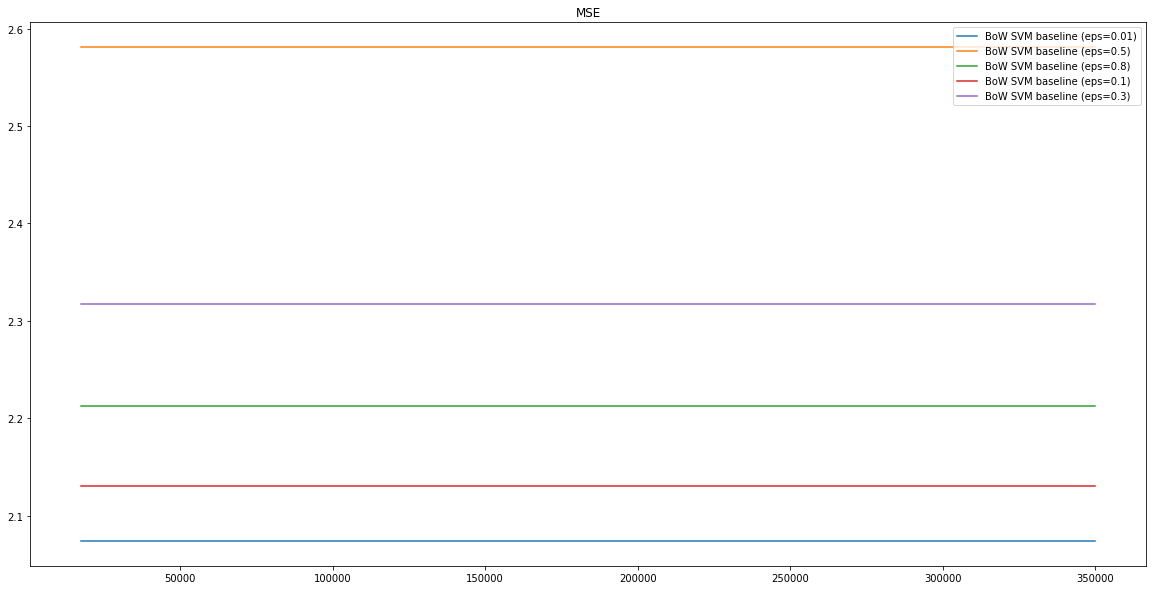

In [166]:
draw_models(svm_baselines, 'baseline', [], 1)

### Fasttext-embeds

In [68]:
from gensim.models import KeyedVectors

Slow version of gensim.models.doc2vec is being used


In [69]:
en_fasttext_model = KeyedVectors.load_word2vec_format('extras/fasttext/wiki.en.vec')

fasttext_embedding_matrix = np.zeros((len(word_index) + 1, FASTTEXT_EMBEDDING_DIM))
for word, i in word_index.items():
    if word in en_fasttext_model:
        # words not found in embedding index will be all-zeros.
        fasttext_embedding_matrix[i] = en_fasttext_model[word]

### Word2vec-embeds

In [ ]:
en_w2v_model = KeyedVectors.load_word2vec_format('extras/word2vec/gnews.en.bin', binary=True) 
    
w2v_embedding_matrix = np.zeros((len(word_index) + 1, WORD2VEC_EMBEDDING_DIM))
for word, i in word_index.items():
    if word in en_w2v_model:
        # words not found in embedding index will be all-zeros.
        w2v_embedding_matrix[i] = en_w2v_model[word]

<h2>DSSM Baseline</h2>

In [107]:
from keras.models import Sequential
from keras.layers import Dense, Embedding 
from keras.layers import LSTM, GRU, Bidirectional
from keras.layers import Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, MaxPooling1D
from keras.optimizers import SGD

In [73]:
def split_data(data, n_intervals = N_INTERVALS):
    n_total = len(data)
    borders = [0] + [int(n_total*(i + 1)/n_intervals) for i in range(n_intervals)]
    return [data[borders[i] : borders[i+1]] for i in range(n_intervals)]

In [131]:
def build_dssm_ft_model(_lr):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                FASTTEXT_EMBEDDING_DIM,
                                weights=[fasttext_embedding_matrix],
                                input_length=MAXLEN,
                                trainable=False))
    
    model.add(GlobalAveragePooling1D())
     
    model.add(Dense(100, activation='relu')) 
    model.add(Dense(100, activation='relu'))
    
    model.add(Dense(1, activation='linear'))

    nesterov = SGD(lr=_lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error',
                  optimizer=nesterov,
                  metrics=['mae'])

    print('Train...')
    x_train_batches = split_data(x_train)
    y_train_batches = split_data(y_train)
    
    evals = []
    for x_train_batch, y_train_batch  in zip(x_train_batches, y_train_batches):  
        model.fit(x_train_batch, y_train_batch,
                  batch_size=10,
                  epochs=1,
                  validation_data=(x_val[:2000], y_val[:2000]))
        evals.append(model.evaluate(x_val[2000:22000], y_val[2000:22000]))
        
    return model, evals
 
trained_models['Dssm AVG'] = build_dssm_ft_model(0.001) 

Train...
Train on 17500 samples, validate on 2000 samples
Epoch 1/1
19488/20000 [============================>.] - ETA: 0sTrain on 17500 samples, validate on 2000 samples
Epoch 1/1
19904/20000 [============================>.] - ETA: 0sTrain on 17500 samples, validate on 2000 samples
Epoch 1/1
19424/20000 [============================>.] - ETA: 0sTrain on 17500 samples, validate on 2000 samples
Epoch 1/1
19808/20000 [============================>.] - ETA: 0sTrain on 17500 samples, validate on 2000 samples
Epoch 1/1
19552/20000 [============================>.] - ETA: 0sTrain on 17500 samples, validate on 2000 samples
Epoch 1/1
19456/20000 [============================>.] - ETA: 0sTrain on 17500 samples, validate on 2000 samples
Epoch 1/1
19744/20000 [============================>.] - ETA: 0sTrain on 17500 samples, validate on 2000 samples
Epoch 1/1
19552/20000 [============================>.] - ETA: 0sTrain on 17500 samples, validate on 2000 samples
Epoch 1/1
19968/20000 [===============

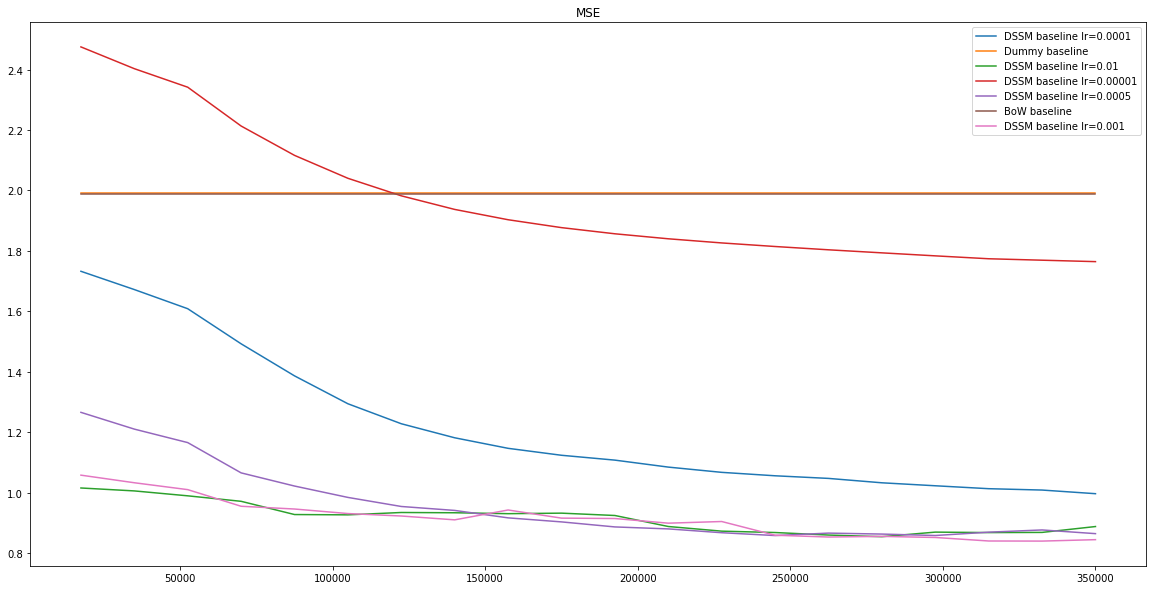

In [162]:
draw_models(trained_models, 'baseline', [], 5)

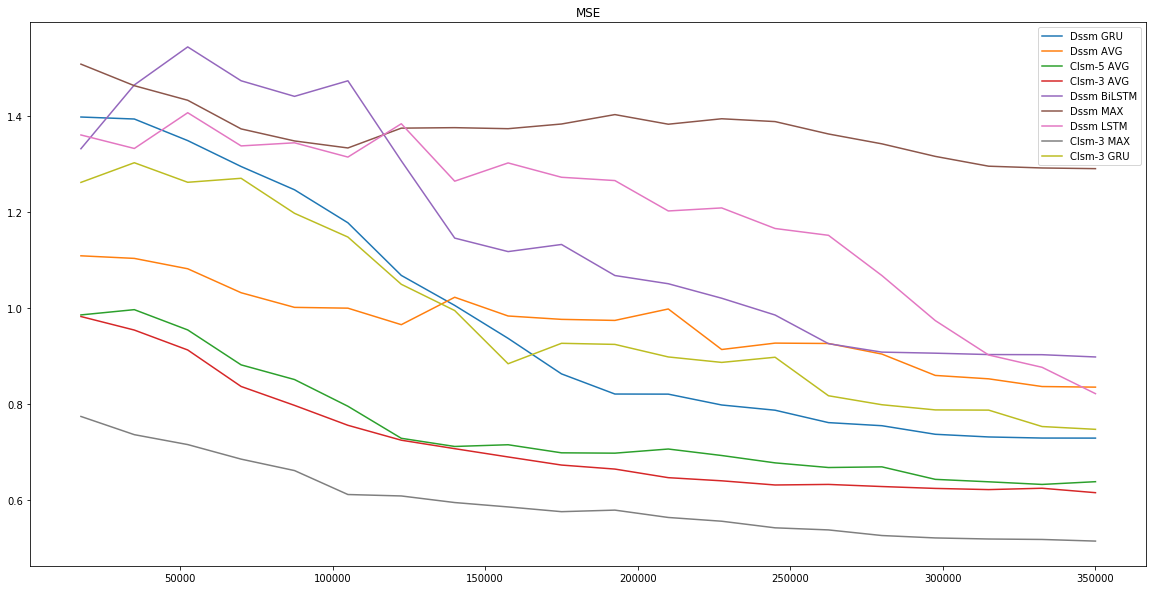

In [153]:
draw_models(trained_models, '', ['non', 'baseline'], 5)

## RNNs

In [ ]:
def build_lstm_fasttext_model(_lr):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                FASTTEXT_EMBEDDING_DIM,
                                weights=[fasttext_embedding_matrix],
                                input_length=MAXLEN,
                                trainable=False))
    model.add(LSTM(300, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # try using different optimizers and different optimizer configs
    nesterov = SGD(lr=_lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error',
                  optimizer=nesterov,
                  metrics=['mae'])

    print('Train...')
    x_train_batches = split_data(x_train)
    y_train_batches = split_data(y_train)
    
    evals = []
    
    for x_train_batch, y_train_batch  in zip(x_train_batches, y_train_batches):  
        model.fit(x_train_batch, y_train_batch,
                  batch_size=10,
                  epochs=1,
                  validation_data=(x_val[:2000], y_val[:2000]))
        evals.append(model.evaluate(x_val[2000:22000], y_val[2000:22000]))
        
    return model, evals

trained_models['LSTM'] = build_lstm_fasttext_model(0.001)

Train...
Train on 17500 samples, validate on 2000 samples
Epoch 1/1
20000/20000 [==============================] - 106s   
Train on 17500 samples, validate on 2000 samples
Epoch 1/1
 3760/17500 [=====>........................] - ETA: 233s - loss: 1.5015 - mean_absolute_error: 0.9870

In [ ]:
def build_gru_fasttext_model(_lr):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                FASTTEXT_EMBEDDING_DIM,
                                weights=[fasttext_embedding_matrix],
                                input_length=MAXLEN,
                                trainable=False))
    model.add(GRU(300, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear'))

    nesterov = SGD(lr=_lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error',
                  optimizer=nesterov,
                  metrics=['mae'])

    print('Train...')
    x_train_batches = split_data(x_train)
    y_train_batches = split_data(y_train)
    
    evals = []
    for x_train_batch, y_train_batch  in zip(x_train_batches, y_train_batches):  
        model.fit(x_train_batch, y_train_batch,
                  batch_size=10,
                  epochs=1,
                  validation_data=(x_val[:2000], y_val[:2000]))
        evals.append(model.evaluate(x_val[2000:22000], y_val[2000:22000]))
        
    return model, evals

trained_models['GRU'] = build_gru_fasttext_model(0.001) 

<h3> Bidirectional </h3>

In [ ]:
def build_bi_lstm_fasttext_model(_lr):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                FASTTEXT_EMBEDDING_DIM,
                                weights=[fasttext_embedding_matrix],
                                input_length=MAXLEN,
                                trainable=False))
    model.add(Bidirectional(LSTM(300, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear'))

    nesterov = SGD(lr=_lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error',
                  optimizer=nesterov,
                  metrics=['mae'])

    print('Train...')
    x_train_batches = split_data(x_train)
    y_train_batches = split_data(y_train)
    
    evals = []
    for x_train_batch, y_train_batch  in zip(x_train_batches, y_train_batches):  
        model.fit(x_train_batch, y_train_batch,
                  batch_size=10,
                  epochs=1,
                  validation_data=(x_val[:2000], y_val[:2000]))
        evals.append(model.evaluate(x_val[2000:22000], y_val[2000:22000]))
        
    return model, evals

trained_models['BiLSTM'] = build_bi_lstm_fasttext_model(0.001) 

In [ ]:
def build_bi_gru_fasttext_model(_lr):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                FASTTEXT_EMBEDDING_DIM,
                                weights=[fasttext_embedding_matrix],
                                input_length=MAXLEN,
                                trainable=False))
    model.add(Bidirectional(GRU(300, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear'))

    nesterov = SGD(lr=_lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error',
                  optimizer=nesterov,
                  metrics=['mae'])

    print('Train...')
    x_train_batches = split_data(x_train)
    y_train_batches = split_data(y_train)
    
    evals = []
    for x_train_batch, y_train_batch  in zip(x_train_batches, y_train_batches):  
        model.fit(x_train_batch, y_train_batch,
                  batch_size=10,
                  epochs=1,
                  validation_data=(x_val[:2000], y_val[:2000]))
        evals.append(model.evaluate(x_val[2000:22000], y_val[2000:22000]))
        
    return model, evals

trained_models['BiGRU'] = build_bi_gru_fasttext_model(0.001) 

Выводы по RNN:
1. GRU > LSTM 
2. w2v ~ fasttext
3. Bidirect жжет, но слабо
4. нет возможности дообучить веса слов: слишком долго.

# DSSM

<h2>Conv DSSM</h2>

In [96]:
from keras.layers.core import Reshape

EMPTY_TOKEN=0

def resplit(tokens, n, empty_token=EMPTY_TOKEN):
    extended = [empty_token] * n + list(tokens) + [empty_token] * n
    return np.array([extended[i: i+2*n + 1] for i in range(len(tokens))]).flatten()

def conv_preprocess_data(data, window_size):
    assert(window_size%2 == 1)
    return np.array([resplit(row, window_size//2) for row in data])

conv_preprocess_data(x_val, 3).shape

(50000, 300)

In [ ]:
def build_convdssm_ft_model(window_size, _lr, is_trainable=False):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                FASTTEXT_EMBEDDING_DIM,
                                weights=[fasttext_embedding_matrix],
                                input_length=window_size * MAXLEN,
                                trainable=is_trainable))
    
    model.add(Reshape((MAXLEN, window_size * FASTTEXT_EMBEDDING_DIM)))
    model.add(Dense(FASTTEXT_EMBEDDING_DIM, activation='relu'))
    model.add(GlobalMaxPooling1D())
     
    model.add(Dense(100, activation='relu')) 
    model.add(Dense(100, activation='relu'))
    
    model.add(Dense(1, activation='linear'))

    nesterov = SGD(lr=_lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error',
                  optimizer=nesterov,
                  metrics=['mae'])
    
    x_val_conv = conv_preprocess_data(x_val, window_size) 

    print('Train...')
    x_train_batches = split_data(conv_preprocess_data(x_train, window_size))
    y_train_batches = split_data(y_train)
    
    evals = []
    for x_train_batch, y_train_batch  in zip(x_train_batches, y_train_batches):   
        model.fit(x_train_batch, y_train_batch,
                  batch_size=10,
                  epochs=1,
                  validation_data=(x_val_conv[:2000], y_val[:2000]))
        evals.append(model.evaluate(x_val_conv[2000:22000], y_val[2000:22000])) 
        
    return model, evals

trained_models['Clsm-3 MAX (non-fixed)'] = build_convdssm_ft_model(3, 0.001, True) 

## Conv GRU

In [ ]:
def build_conv_lstm_ft_model(window_size, _lr):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                FASTTEXT_EMBEDDING_DIM,
                                weights=[fasttext_embedding_matrix],
                                input_length=window_size * MAXLEN,
                                trainable=False))
    
    model.add(Reshape((MAXLEN, window_size * FASTTEXT_EMBEDDING_DIM)))
    model.add(Dense(FASTTEXT_EMBEDDING_DIM, activation='relu'))
    model.add(LSTM(300, dropout=0.2, recurrent_dropout=0.2))
     
    model.add(Dense(100, activation='relu')) 
    model.add(Dense(100, activation='relu'))
    
    model.add(Dense(1, activation='linear'))

    nesterov = SGD(lr=_lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error',
                  optimizer=nesterov,
                  metrics=['mae'])
    
    x_val_conv = conv_preprocess_data(x_val, window_size) 

    print('Train...')
    x_train_batches = split_data(conv_preprocess_data(x_train, window_size))
    y_train_batches = split_data(y_train)
    
    evals = []
    for x_train_batch, y_train_batch  in zip(x_train_batches, y_train_batches):   
        model.fit(x_train_batch, y_train_batch,
                  batch_size=10,
                  epochs=1,
                  validation_data=(x_val_conv[:2000], y_val[:2000]))
        evals.append(model.evaluate(x_val_conv[2000:22000], y_val[2000:22000])) 
        
    return model, evals

trained_models['Conv3-LSTM'] = build_conv_lstm_ft_model(3, 0.001)  

In [ ]:
def build_conv_gru_ft_model(window_size, _lr):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                FASTTEXT_EMBEDDING_DIM,
                                weights=[fasttext_embedding_matrix],
                                input_length=window_size * MAXLEN,
                                trainable=False))
    
    model.add(Reshape((MAXLEN, window_size * FASTTEXT_EMBEDDING_DIM)))
    model.add(Dense(FASTTEXT_EMBEDDING_DIM, activation='relu'))
    model.add(GRU(300, dropout=0.2, recurrent_dropout=0.2))
     
    model.add(Dense(100, activation='relu')) 
    model.add(Dense(100, activation='relu'))
    
    model.add(Dense(1, activation='linear'))

    nesterov = SGD(lr=_lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error',
                  optimizer=nesterov,
                  metrics=['mae'])
    
    x_val_conv = conv_preprocess_data(x_val, window_size) 

    print('Train...')
    x_train_batches = split_data(conv_preprocess_data(x_train, window_size))
    y_train_batches = split_data(y_train)
    
    evals = []
    for x_train_batch, y_train_batch  in zip(x_train_batches, y_train_batches):   
        model.fit(x_train_batch, y_train_batch,
                  batch_size=10,
                  epochs=1,
                  validation_data=(x_val_conv[:2000], y_val[:2000]))
        evals.append(model.evaluate(x_val_conv[2000:22000], y_val[2000:22000])) 
        
    return model, evals

trained_models['Conv3-GRU'] = build_conv_gru_ft_model(3, 0.001)  

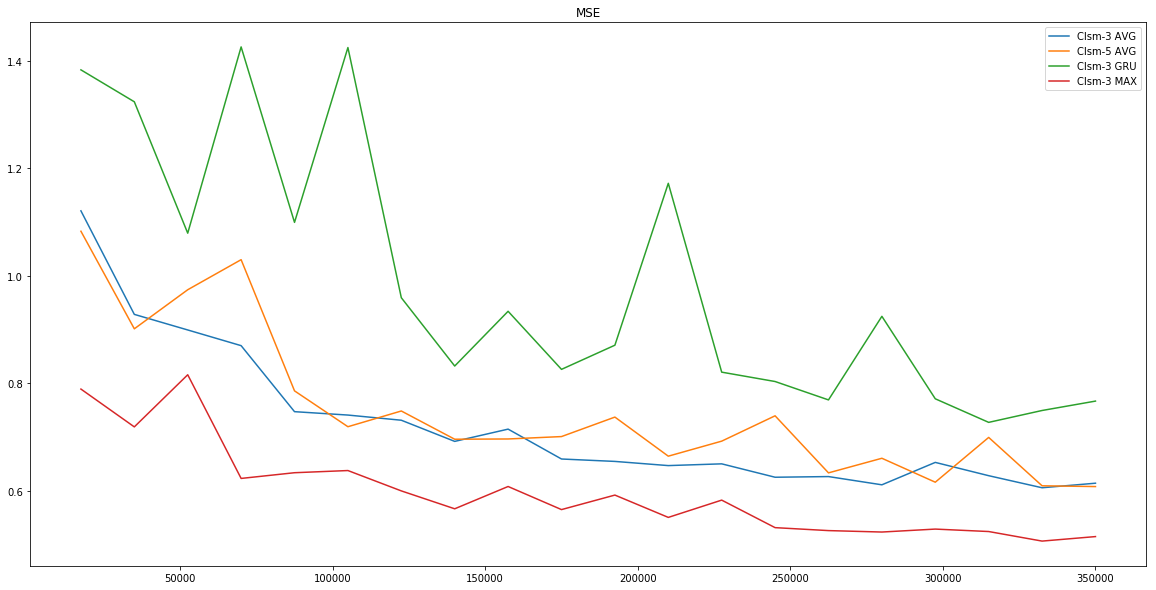

In [148]:
draw_models(trained_models, 'Clsm', 'non')

## Check models

In [ ]:
from keras import backend as K

In [ ]:
def check_layers(model):
    inp = model.input                                           # input placeholder
    outputs = [layer.output for layer in model.layers]          # all layer outputs
    functors = [K.function([inp]+ [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    # Testing
    test = resplit(np.random.random((100)), 1)[np.newaxis,...]
    layer_outs = [func([test, 1.])[0].shape for func in functors]
    print(layer_outs) 
    
check_layers(trained_models['ConvDSSM word2vec'][0])